In [1]:
import matplotlib
import copy
import logging
#import torch

#from tqdm.autonotebook import tqdm

from data.data_loader import Dataset
from data.germeval2017 import germeval2017_dataset

from misc.preferences import PREFERENCES
#from misc.visualizer import *
from misc.run_configuration import get_default_params, randomize_params
from misc import utils

from optimizer import get_default_optimizer
from criterion import NllLoss, LossCombiner

from models.transformer.encoder import TransformerEncoder
from models.softmax_output import SoftmaxOutputLayerWithCommentWiseClass
from models.transformer_tagger import TransformerTagger
from models.jointAspectTagger import JointAspectTagger
from models.transformer.train import Trainer
import pprint

C:\Users\felix\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
PREFERENCES.defaults(
    data_root='./data/germeval2017',
    data_train='train_v1.4.tsv',    
    data_validation='dev_v1.4.tsv',
    data_test='test_TIMESTAMP1.tsv',
    early_stopping='highest_5_F1'
)
def load(hp, logger):
    dataset = Dataset(
        'germeval',
        logger,
        hp,
        source_index=0,
        target_vocab_index=2,
        data_path=PREFERENCES.data_root,
        train_file=PREFERENCES.data_train,
        valid_file=PREFERENCES.data_validation,
        test_file=PREFERENCES.data_test,
        file_format='.tsv',
        init_token=None,
        eos_token=None
    )
    dataset.load_data(germeval2017_dataset, verbose=False)
    return dataset

In [3]:
def load_model(dataset, hp, experiment_name):
    loss = LossCombiner(4, dataset.class_weights, NllLoss)
    transformer = TransformerEncoder(dataset.source_embedding,
                                     hyperparameters=hp)
    tagging_softmax = SoftmaxOutputLayerWithCommentWiseClass(hp.model_size, dataset.target_size)
    model = JointAspectTagger(transformer, hp.model_size, 4, 20, dataset.target_names)
    optimizer = get_default_optimizer(model, hp)
    trainer = Trainer(
                        model,
                        loss,
                        optimizer,
                        hp,
                        dataset,
                        experiment_name,
                        enable_tensorboard=False,
                        verbose=False)
    return trainer

In [4]:
experiment_name = 'Bla'
use_cuda = True

In [5]:
# get general logger just for search
experiment_name = utils.create_loggers(experiment_name=experiment_name)
logger = logging.getLogger(__name__)
logger.info('Run hyper parameter random grid search for experiment with name ' + experiment_name)

Log path is  C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\logs\Bla\20190222\10


In [6]:
utils.get_current_git_commit()
logger.info('Current commit: ' + utils.get_current_git_commit())

In [7]:
num_optim_iterations = 2
logger.info('num_optim_iterations: ' + str(num_optim_iterations))

In [8]:
random_grid_search_ranges = {
    'batch_size': (1, 15),
    'num_encoder_blocks': (1, 10),
    'pointwise_layer_size': (32, 4000),
    'clip_comments_to': (12, 500),
    'learning_rate': (0, 1e-2),
    'learning_rate_factor': (1e-3, 4),
    'learning_rate_warmup': (1000, 10000),
    'optim_adam_beta1': (0.5, 0.99),
    'optim_adam_beta2': (0.5, 0.99),
    'dropout_rate': (0, 0.8),
    'transformer_config': {
        'transformer_heads': [1, 2, 3, 4, 5, 6, 10, 12, 15, 20]
    }
}
logger.info(pprint.pformat(random_grid_search_ranges, indent=2))

In [9]:
default_hp = get_default_params(use_cuda)
logger.info(default_hp)
print(default_hp)

+------------------------------------+
|          Hyperparameters           |
+-------------------------+----------+
|        Parameter        |  Value   |
+-------------------------+----------+
|        batch_size       |    12    |
|        model_size       |   300    |
|    learning_rate_type   |   noam   |
|      learning_rate      |    0     |
|   learning_rate_warmup  |   4800   |
|   learning_rate_factor  |    2     |
|     optim_adam_beta1    |   0.9    |
|     optim_adam_beta2    |   0.98   |
|      early_stopping     |    5     |
|         use_cuda        |   True   |
|       n_enc_blocks      |    3     |
|         n_heads         |    6     |
|           d_k           |    50    |
|           d_v           |    50    |
|       dropout_rate      |   0.1    |
|   pointwise_layer_size  |   2048   |
| log_every_xth_iteration |    -1    |
|        num_epochs       |    1     |
|      embedding_type     | fasttext |
|      embedding_name     |    6B    |
|      embedding_dim     



+-------------------------------------------------+
Optim Iteration: 0


+-------------------------------------------------+
|                 Hyperparameters                 |
+-------------------------+-----------------------+
|        Parameter        |         Value         |
+-------------------------+-----------------------+
|        batch_size       |           5           |
|        model_size       |          300          |
|    learning_rate_type   |          noam         |
|      learning_rate      | 0.0023524448674036857 |
|   learning_rate_warmup  |   1606.0264351324481  |
|   learning_rate_factor  |   3.8200355155732253  |
|     optim_adam_beta1    |   0.7730890504317591  |
|     optim_adam_beta2    |   0.5286886211351404  |
|      early_stopping     |           5           |
|         use_cuda        |          True         |
|       n_enc_blocks      |           2           |
|         n_heads         |           6           |
|           d_k           |           50 

A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\train_v1.pkl.
Model train_v1 successfully saved.


A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\dev_v1.pkl.
Model dev_v1 successfully saved.


A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\test_TIMESTAMP1.pkl.
Model test_TIMESTAMP1 successfully saved.
pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized





A Jupyter Widget

# EP	# IT	tr loss		val loss	f1		acc		duration / total time
1	3409	217.19		34.10		0.244		0.939		9.36m - 9.4m / 0.0m



A Jupyter Widget

A Jupyter Widget

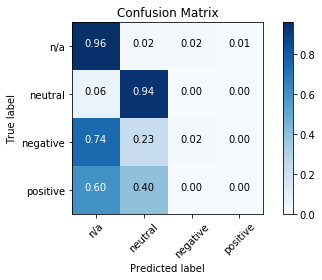

+-------------------------------------------------+
Best Valid Result: 0.24245329834802581
+-------------------------------------------------+


###################################################



+-------------------------------------------------+
Optim Iteration: 1


+-------------------------------------------------+
|                 Hyperparameters                 |
+-------------------------+-----------------------+
|        Parameter        |         Value         |
+-------------------------+-----------------------+
|        batch_size       |           11          |
|        model_size       |          300          |
|    learning_rate_type   |          noam         |
|      learning_rate      | 0.0027502931836911925 |
|   learning_rate_warmup  |   7628.240927476111   |
|   learning_rate_factor  |   0.8936197418571422  |
|     optim_adam_beta1    |   0.8315827488372265  |
|     optim_adam_beta2    |   0.9371679881753743  |
|      early_stopping     |           5           |

A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\train_v1.pkl.
Model train_v1 successfully saved.


A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\dev_v1.pkl.
Model dev_v1 successfully saved.


A Jupyter Widget


Trying to save loaded dataset to C:\Users\felix\OneDrive\Studium\Studium\6. Semester\MA\Project\ABSA-Transformer\data\cache\test_TIMESTAMP1.pkl.
Model test_TIMESTAMP1 successfully saved.
pre_training - DEBUG - 20 initialized
pre_training - DEBUG - Initilize parameters with nn.init.xavier_uniform_
pre_training - DEBUG - Tagger initialized





A Jupyter Widget

In [ ]:
dataset_logger = logging.getLogger('data_loader')
best_f1 = 0.0
best_model = None
best_hp = None
best_iteration = -1
for optim_iteration in range(num_optim_iterations):
        
    print(f'\n\n+-------------------------------------------------+\nOptim Iteration: {optim_iteration}\n\n')
    logger.info(f'\n\n=================================\nOptim Iteration: {optim_iteration}\n=================================')
    
    # generate iteration hyper parameters
    hp = randomize_params(default_hp, random_grid_search_ranges)
        
    logger.info('New Params:')
    logger.info(hp)
    print(hp)
    
    logger.debug('Load dataset')
    dataset = load(hp, dataset_logger)
    logger.debug('dataset loaded')
    logger.debug('Load model')
    trainer = load_model(dataset, hp, experiment_name)
    logger.debug('model loaded')
    
    logger.debug('Begin training')
    model = None
    try:
        result = trainer.train(use_cuda=hp.use_cuda, perform_evaluation=False)
        model = result['model']
    except Exception as err:
        logger.exception("Could not complete iteration " + str(optim_iteration))
        print(f'Could not complete iteration {optim_iteration} because of {str(err)}')
        continue
        
    # perform evaluation and log results
    result = None
    try:
        result = trainer.perform_final_evaluation(use_test_set=False, verbose=False)
    except Exception as err:
        logger.exception("Could not complete iteration evaluation for it " + str(optim_iteration))
        print(f'Could not complete iteration {optim_iteration} evaluation because of {str(err)}')
        continue
    
    it_f1 = result[1][1]
    if best_f1 < it_f1:
        best_f1 = it_f1
        best_model = model
        best_hp = copy.copy(hp)
        best_iteration = optim_iteration
        print('+-------------------------------------------------+')
        print(f'Best Valid Result: {best_f1}')
        print('+-------------------------------------------------+')
    else:
        print(f'\nValid Result: {best_f1}\n')    
    print('\n\n###################################################\n')
    
print('Best iteration: ' + str(best_iteration))
print('Best f1: ' + str(best_f1))
print('Best HP:')
print(best_hp)